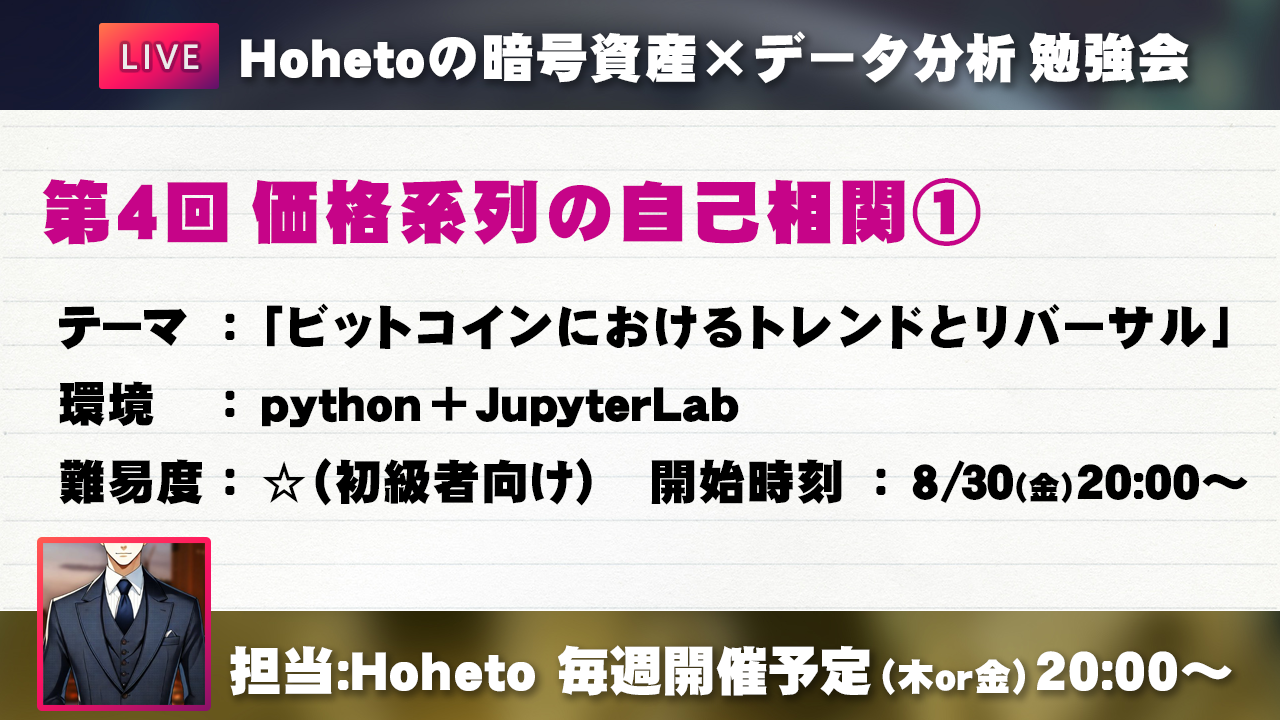

In [1]:
from IPython.display import Image

Image('./images/04_00.png')

# Hoheto勉強会 第4回 価格系列の自己相関①

## 免責事項

- この勉強会では、過去のデータ分析を中心に行います。未来の値動きを断定したり投資に関するアドバイスを提供するものではありません。
- 投資は自己責任です。この内容に基づいて視聴者様が行う投資判断やその結果について、配信者は一切の責任を負いません。
- 内容には細心の注意を払っておりますが、正確性を完全に保証するものではありません。

## 概要

- ビットコインおよび主要アルトコインについて、時間軸ごとのトレンド、リバーサルの傾向について把握する。

## 前提知識

- Python。pandas、numpyなどのライブラリ。
- Jupyter。

## 内容・難易度

- 難易度☆1つ。

### 元ネタ

- 今回のネタは・・・
- ビットコイン価格における24時間逆張りアノマリーの存在 [ https://note.com/hht/n/nea09d366be7c ]

# 今回の検証の流れ

- ビットコインについて、自己相関を調べる。
- 短期の時間軸ではリバーサル傾向を、長期の時間軸ではトレンド傾向が観察されることを確認する。
- 24時間逆張りアノマリーの存在を確認する。
- 他のアルトコインについても同様に調べてみる。

# 環境設定

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import ccxt
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import warnings
from tqdm import tqdm
from IPython.display import display, HTML, Image

In [4]:
# warning表示off
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 7

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (4, 4)

# データの取得

- それぞれの価格データ（4本値、OHLC）
- BTC
- メジャーアルト
  - ETHUSDT
  - SOLUSDT
  - BNBUSDT
- レガシーアルト
  - XRPUSDT
  - DOGEUSDT
  - BCHUSDT
  - MATICSUDT

In [5]:
symbols = ['BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'BNBUSDT', 'XRPUSDT', 'DOGEUSDT', 'BCHUSDT', 'MATICUSDT']

In [6]:
import pickle

def load_pickle(path):
    with open(path, mode="rb") as f:
        data = pickle.load(f)
        return data

In [7]:
df_dict = load_pickle('./data/04_df_dict.pkl')

In [8]:
df_dict['BTCUSDT']

,open_price,high_price,low_price,close_price,volume,quote_volume,trade_num,buy_volume,quote_buy_volume,symbol,source
dt,,,,,,,,,,,
2020-01-01 00:00:00+00:00,7189.43,7190.52,7172.94,7175.25,583.119,4.186536e+06,921.0,175.877,1.262598e+06,BTCUSDT,binance_usdm
2020-01-01 00:05:00+00:00,7174.71,7186.69,7173.28,7186.69,163.860,1.176440e+06,345.0,127.400,9.147206e+05,BTCUSDT,binance_usdm
2020-01-01 00:10:00+00:00,7186.83,7188.10,7175.70,7176.26,290.358,2.084984e+06,294.0,80.474,5.777864e+05,BTCUSDT,binance_usdm
2020-01-01 00:15:00+00:00,7176.22,7179.41,7172.43,7173.68,189.617,1.360585e+06,326.0,69.584,4.992924e+05,BTCUSDT,binance_usdm
2020-01-01 00:20:00+00:00,7173.50,7176.13,7170.69,7171.81,198.838,1.426225e+06,365.0,46.168,3.311762e+05,BTCUSDT,binance_usdm
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-24 23:35:00+00:00,63927.80,63944.10,63881.00,63892.80,133.991,8.563979e+06,3551.0,60.716,3.880572e+06,BTCUSDT,binance_usdm
2024-08-24 23:40:00+00:00,63892.70,63921.20,63887.00,63894.00,154.875,9.896663e+06,3212.0,97.507,6.230758e+06,BTCUSDT,binance_usdm
2024-08-24 23:45:00+00:00,63894.00,63945.10,63894.00,63945.10,121.691,7.779822e+06,2722.0,70.710,4.520529e+06,BTCUSDT,binance_usdm


## 自己相関の検証

- BTCの価格系列

In [9]:
btc = df_dict['BTCUSDT'].copy()

In [10]:
# 例によって5分足
btc

,open_price,high_price,low_price,close_price,volume,quote_volume,trade_num,buy_volume,quote_buy_volume,symbol,source
dt,,,,,,,,,,,
2020-01-01 00:00:00+00:00,7189.43,7190.52,7172.94,7175.25,583.119,4.186536e+06,921.0,175.877,1.262598e+06,BTCUSDT,binance_usdm
2020-01-01 00:05:00+00:00,7174.71,7186.69,7173.28,7186.69,163.860,1.176440e+06,345.0,127.400,9.147206e+05,BTCUSDT,binance_usdm
2020-01-01 00:10:00+00:00,7186.83,7188.10,7175.70,7176.26,290.358,2.084984e+06,294.0,80.474,5.777864e+05,BTCUSDT,binance_usdm
2020-01-01 00:15:00+00:00,7176.22,7179.41,7172.43,7173.68,189.617,1.360585e+06,326.0,69.584,4.992924e+05,BTCUSDT,binance_usdm
2020-01-01 00:20:00+00:00,7173.50,7176.13,7170.69,7171.81,198.838,1.426225e+06,365.0,46.168,3.311762e+05,BTCUSDT,binance_usdm
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-24 23:35:00+00:00,63927.80,63944.10,63881.00,63892.80,133.991,8.563979e+06,3551.0,60.716,3.880572e+06,BTCUSDT,binance_usdm
2024-08-24 23:40:00+00:00,63892.70,63921.20,63887.00,63894.00,154.875,9.896663e+06,3212.0,97.507,6.230758e+06,BTCUSDT,binance_usdm
2024-08-24 23:45:00+00:00,63894.00,63945.10,63894.00,63945.10,121.691,7.779822e+06,2722.0,70.710,4.520529e+06,BTCUSDT,binance_usdm


## 1時間足

- 1時間足にリサンプリング

In [11]:
btc_1h = btc.resample('1h').agg({'open_price': 'first', 'close_price': 'last'})
btc_1h['ror'] = (btc_1h['close_price'] - btc_1h['open_price']) / btc_1h['open_price']

- 「ある1時間のリターン」と、
  - その1時間前の1時間リターン、
  - その2時間前の1時間リターン、
  - そのk時間前の1時間リターン、
  - ・・・
- の相関を取ってグラフ化する。
- 自己相関係数を期間kの関数として表現したものをコレログラムという。

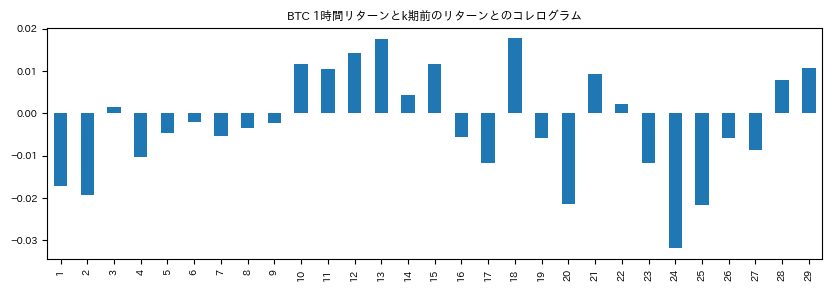

In [12]:
corr = {}
for i in range(1, 30):
    corr[i] = btc_1h['ror'].corr(btc_1h['ror'].shift(i))

plt.figure(figsize=(10, 3))
plt.title('BTC 1時間リターンとk期前のリターンとのコレログラム')
pd.Series(corr).plot(kind='bar');

- コレログラムの累積
- 「ある1時間のリターン」と、
  - その1時間前からの1時間リターン、
  - その2時間前からの2時間リターン、
  - そのk時間前のk時間リターン、
  - ・・・
- の相関を取ってグラフ化する。

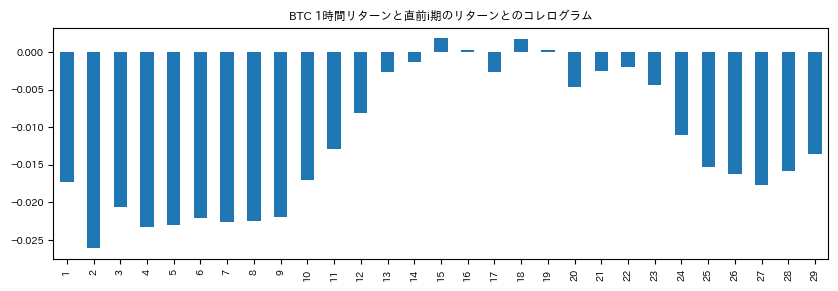

In [13]:
corr = {}
for i in range(1, 30):
    ror = btc_1h['ror'].rolling(i).sum().shift(1)
    corr[i] = btc_1h['ror'].corr(ror)

plt.figure(figsize=(10, 3))
plt.title('BTC 1時間リターンと直前i期のリターンとのコレログラム')
pd.Series(corr).plot(kind='bar');

- トレンドは正の相関、リバーサルは負の相関。

- 直近数時間程度の価格の値動きについて、次の1時間は逆側の値動きが起こる傾向（リバーサルの傾向）を表している。
- あくまで傾向であることに注意。
- また、時期を考慮に入れていないことにも注意。効きやすい時期とそうでない時期があるかもしれない。

## 日足

In [14]:
btc_1d = btc.resample('1d').agg({'open_price': 'first', 'close_price': 'last'})
btc_1d['ror'] = (btc_1d['close_price'] - btc_1d['open_price']) / btc_1d['open_price']
# btc_1d = btc_1d['2021-12-31':]

- 日足のコレログラム。

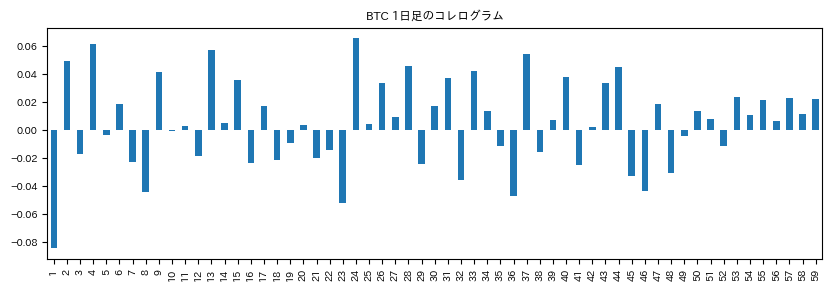

In [15]:
corr = {}
for i in range(1, 60):
    corr[i] = btc_1d['ror'].corr(btc_1d['ror'].shift(i))

plt.figure(figsize=(10, 3))
plt.title('BTC 1日足のコレログラム')
pd.Series(corr).plot(kind='bar');

- 日足のコレログラムの累積。

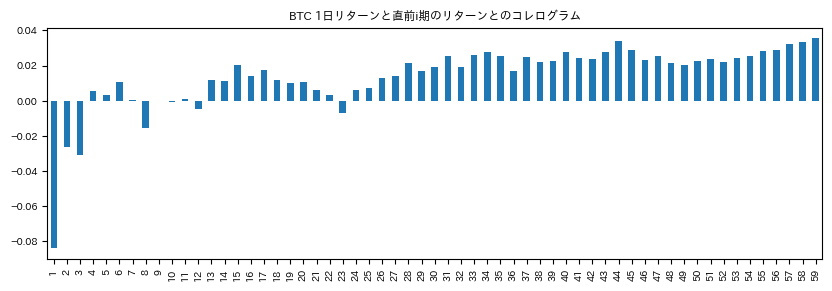

In [16]:
corr = {}
for i in range(1, 60):
    ror = btc_1d['ror'].rolling(i).sum().shift(1)
    corr[i] = btc_1d['ror'].corr(ror)

plt.figure(figsize=(10, 3))
plt.title('BTC 1日リターンと直前i期のリターンとのコレログラム')
pd.Series(corr).plot(kind='bar');

- 直前の1日に対して反発する値動きが起こりやすい傾向にある
- 14日以上の長い期間の値動きに対し、正方向の相関が見て取れる。これが長期に渡るトレンド傾向を表している。
- これも、あくまで傾向であることに注意。
- 米株のような右肩上がりのアセットについても同様の傾向が確認できるわけだが、かといって未来永劫この傾向が続くとは限らないことに注意。

- 参考 トレンドを利用した戦略（コスト控除なしなのであくまで参考）
  - 直近30日間の累積リターンがプラスなら次の日ロング、マイナスなら次の日ショート。
  - 直近のレンジ相場でがちゃがちゃやってそう。

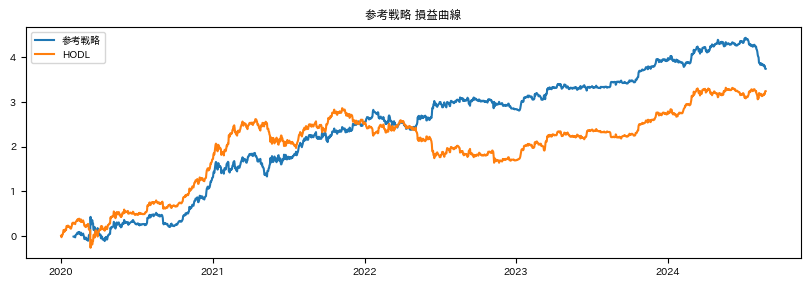

In [17]:
btc_1d['signal'] = np.sign(btc_1d['ror'].rolling(30).sum().shift(1))
btc_1d['pnl'] = btc_1d['signal'] * btc_1d['ror']
plt.figure(figsize=(10, 3))
plt.title('参考戦略 損益曲線')
plt.plot(btc_1d['pnl'].cumsum(), label='参考戦略')
plt.plot(btc_1d['ror'].cumsum(), label='HODL')
plt.legend();

# 24時間逆張りアノマリー

- 24時間後に逆相関が観測できる。

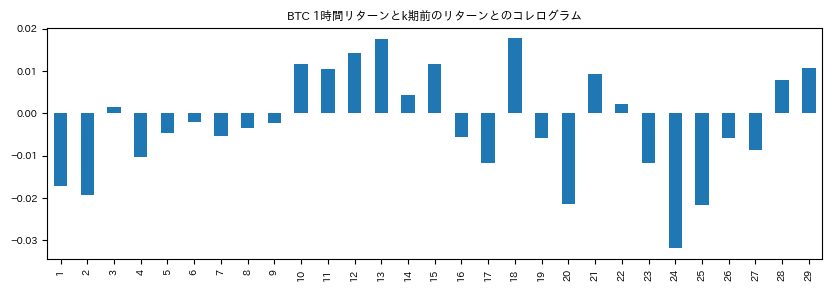

In [18]:
corr = {}
for i in range(1, 30):
    corr[i] = btc_1h['ror'].corr(btc_1h['ror'].shift(i))

plt.figure(figsize=(10, 3))
plt.title('BTC 1時間リターンとk期前のリターンとのコレログラム')
pd.Series(corr).plot(kind='bar');

- 4時間足にリサンプリング

In [19]:
btc_4h = btc.resample('4h').agg({'open_price': 'first', 'close_price': 'last'})
btc_4h['ror'] = (btc_4h['close_price'] - btc_4h['open_price']) / btc_4h['open_price']

- 24時間前（4時間足であるから6期前）に逆相関を確認できる。

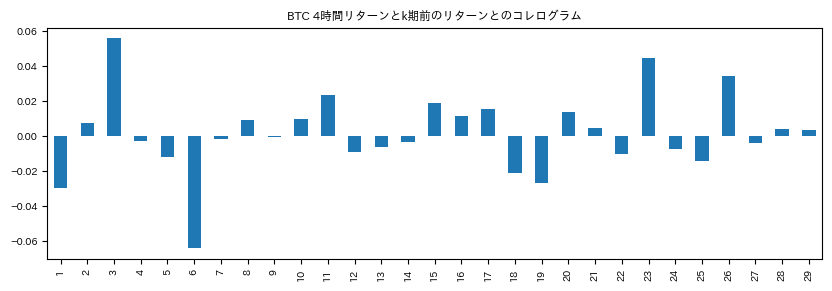

In [20]:
corr = {}
for i in range(1, 30):
    corr[i] = btc_4h['ror'].corr(btc_4h['ror'].shift(i))

plt.figure(figsize=(10, 3))
plt.title('BTC 4時間リターンとk期前のリターンとのコレログラム')
pd.Series(corr).plot(kind='bar');

- 戦略1
  - 4時間足で6期前のリターンがマイナスならロング、プラスならショート。
  - 一応、右肩上がりになるのである。

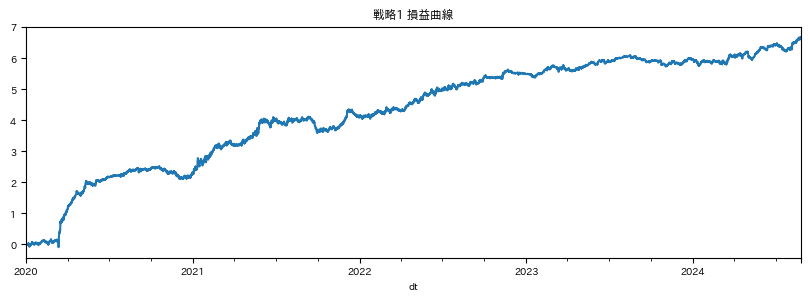

In [21]:
plt.figure(figsize=(10, 3))
plt.title('戦略1 損益曲線')
btc_4h['signal'] = -np.sign(btc_4h['ror'].shift(6))
btc_4h['pnl'] = btc_4h['signal'] * btc_4h['ror']
btc_4h['pnl'].cumsum().plot();

- 残念だがこのままだとコストを加味すると利益は出ない。

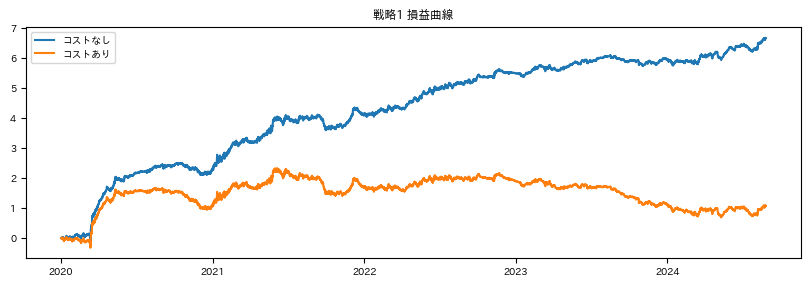

In [22]:
taker_fee = 0.0005
plt.figure(figsize=(10, 3))
plt.title('戦略1 損益曲線')
btc_4h['signal'] = -np.sign(btc_4h['ror'].shift(6))
btc_4h['pnl'] = btc_4h['signal'] * btc_4h['ror']
btc_4h['fee'] = np.abs(btc_4h['signal'].diff()) * taker_fee
plt.plot(btc_4h['pnl'].cumsum(), label='コストなし')
plt.plot(btc_4h['pnl'].cumsum() - btc_4h['fee'].cumsum(), label='コストあり')
plt.legend();

# 他のアルトコインについて

- メジャーアルト
  - ETHUSDT
  - SOLUSDT
  - BNBUSDT
- レガシーアルト
  - XRPUSDT
  - DOGEUSDT
  - BCHUSDT
  - MATICSUDT

In [23]:
def plot_charts(symbol):
    plt.figure(figsize=(15, 4))
    for j, offset in enumerate(['0h', '1h', '2h', '3h']):
        df = df_dict[symbol].resample('4h', offset=offset).agg({'open_price': 'first', 'close_price': 'last'})
        df['ror'] = (df['close_price'] - df['open_price']) / df['open_price']
        df['signal'] = -np.sign(df['ror'].shift(6))
        # コレログラム
        plt.subplot(2, 4, j+1)
        corr = {}
        for i in range(1, 30):
            corr[i] = df['ror'].corr(df['ror'].shift(i))
        plt.title(f'{symbol} 4時間足 offset={offset} リターンコレログラム')
        pd.Series(corr).plot(kind='bar');
        # 損益曲線
        plt.subplot(2, 4, j+5)
        plt.title(f'{symbol} 4時間足 offset={offset} 戦略1 損益曲線')
        df['pnl'] = df['signal'] * df['ror']
        df['pnl'].cumsum().plot()
    plt.tight_layout();

- オフセットも考慮して確認してみる。

- BTC

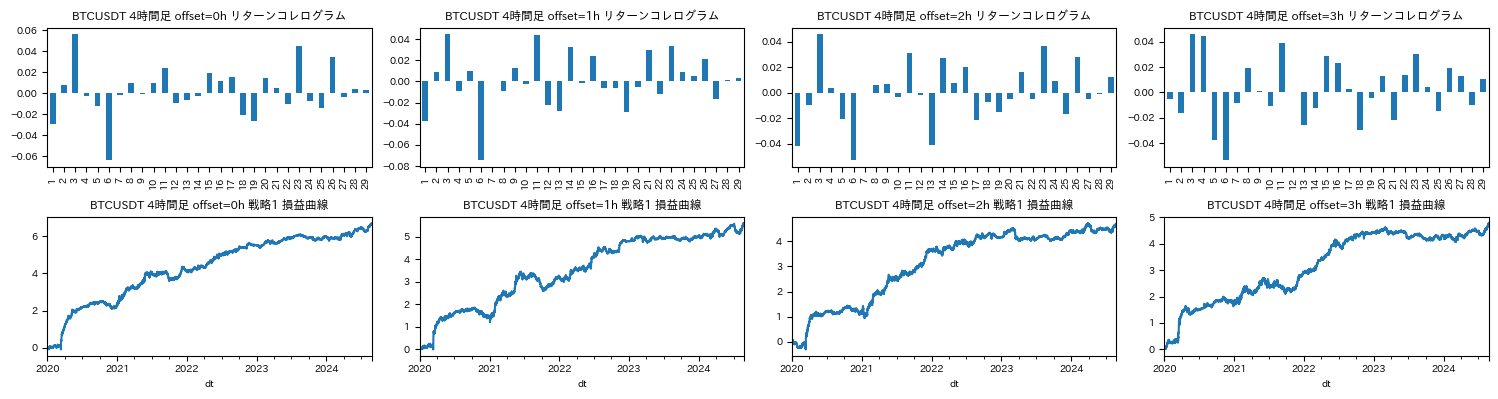

In [24]:
plot_charts('BTCUSDT')

- ETH

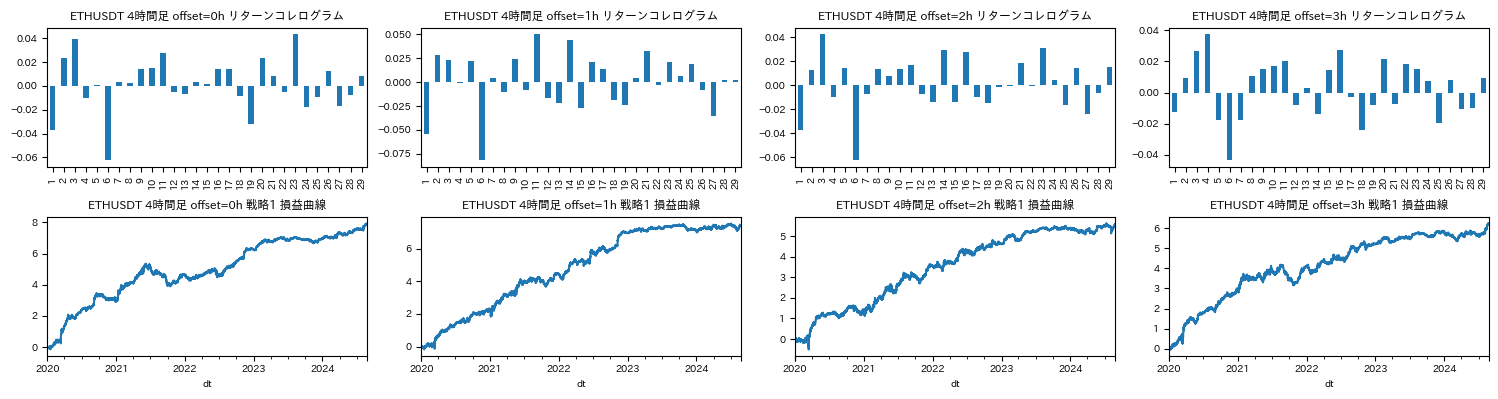

In [25]:
plot_charts('ETHUSDT')

- SOL

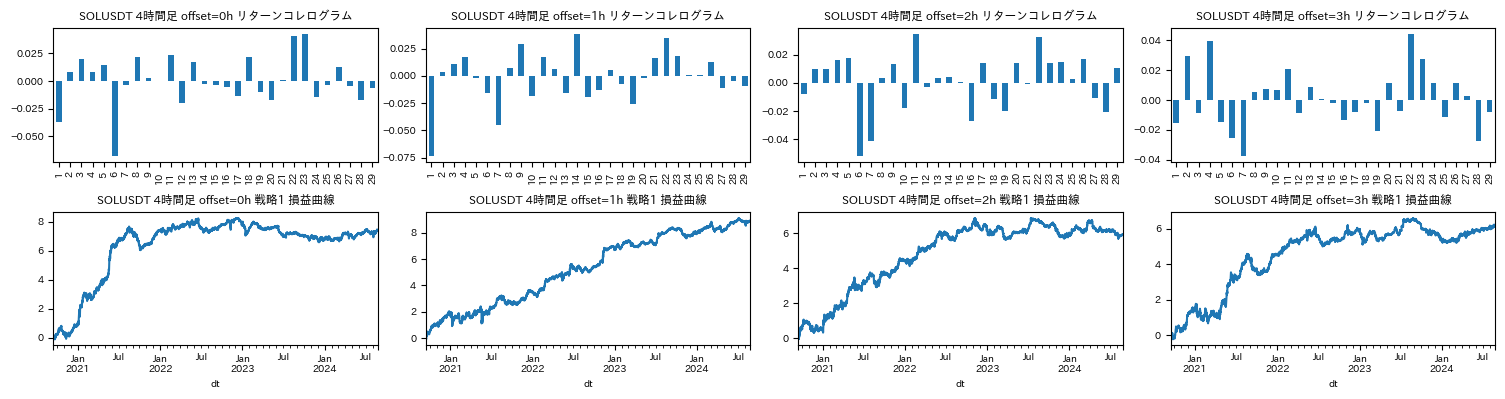

In [26]:
plot_charts('SOLUSDT')

- BNB

In [ ]:
plot_charts('BNBUSDT')

KeyboardInterrupt: 

- XRP

In [ ]:
plot_charts('XRPUSDT')

- DOGE

In [ ]:
plot_charts('DOGEUSDT')

- BCH

In [ ]:
plot_charts('BCHUSDT')

- MATIC

In [ ]:
plot_charts('MATICUSDT')

# 本日のまとめ

- ビットコインの値動きの傾向として、短期（数時間）ではリバーサル、長期（14日以上）ではトレンドを確認できた。
- 24時間間隔で価格が逆方向に動きやすい「24時間逆張りアノマリー」を確認できた。
- ただし、BTC、ETH以外では2023年以降、このアノマリーは弱まっている。
- コストを加味すると、このアノマリーだけで利益を出すのは難しい。
  - あくまで傾向として把握すること。
  - 自己相関分析は時系列分析の基本なので、引き出しに入れておく（本来は季節要因などを確認するために使う）。
  - より込み入った分析をするなら
    - この傾向が効きやすいのはどんなときか？
    - 値幅を稼げるのはどのようなときか？
    - このアノマリーの要因となる動きを調べる　など。

# 次回

- 来週開催予定。
- 内容は未定です。